# Notebook to create the MIRI MRS dither patterns #

In [1]:
import os as os
import numpy as np
import datetime
from numpy.testing import utils
from astropy.io import ascii
from numpy.testing import assert_allclose
import pdb as pdb

import matplotlib as mpl
import matplotlib.pyplot as plt

import miricoord.mrs.mrs_tools as mrst
import miricoord.mrs.makedither.makedither_mrs as mrsd
import miricoord.mrs.makesiaf.makesiaf_mrs as makesiaf

### Output Files ###
Output will be written to $MIRICOORD_DATA_DIR/dithers/temp/ by default

In [2]:
# Look for if the default base output directory (MIRICOORD_DATA_DIR)
# was defined already.  If not, set it to something here.
if "MIRICOORD_DATA_DIR" in os.environ:
    data_dir=os.getenv('MIRICOORD_DATA_DIR')+'dithers/temp/'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
else:
    data_dir='./'

In [4]:
now=datetime.datetime.now()
nowstring=now.ctime()
nowstring=nowstring[4:8]+nowstring[20:24]

### Previous Dither File ###
Read in the previous set of dithers from the data directory within miricoord.  Note that code required here might change as the old format is updated.

In [5]:
prevfile=os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/dithers/mrsdither-PRDOPSSOC-M-025.txt')

In [6]:
data=ascii.read(prevfile)
v2_old,v3_old=data['v2'].data,data['v3'].data
v2_old_ch1,v3_old_ch1=v2_old[0:8],v3_old[0:8]
v2_old_ch2,v3_old_ch2=v2_old[8:16],v3_old[8:16]
v2_old_ch3,v3_old_ch3=v2_old[16:24],v3_old[16:24]
v2_old_ch4,v3_old_ch4=v2_old[24:32],v3_old[24:32]
v2_old_eall,v3_old_eall=v2_old[32:36],v3_old[32:36]
v2_old_ech1,v3_old_ech1=v2_old[36:40],v3_old[36:40]
v2_old_ech2,v3_old_ech2=v2_old[40:44],v3_old[40:44]
v2_old_ech3,v3_old_ech3=v2_old[44:48],v3_old[44:48]
v2_old_ech4,v3_old_ech4=v2_old[48:52],v3_old[48:52]

### Use CDP-8b distortion solution (change this if necessary to use a different one) ###

In [7]:
mrst.set_toolversion('cdp8b')
mrst.version()

'cdp8b'

In [8]:
# Define the field boundaries used by the SIAF
# We create all of this anew instead of simply reading the SIAF because
# sometimes it takes a long time to get the SIAF PRD updated
siaf1A=makesiaf.create_siaf_oneband('1A')
siaf1B=makesiaf.create_siaf_oneband('1B')
siaf1C=makesiaf.create_siaf_oneband('1C')

siaf2A=makesiaf.create_siaf_oneband('2A')
siaf2B=makesiaf.create_siaf_oneband('2B')
siaf2C=makesiaf.create_siaf_oneband('2C')

siaf3A=makesiaf.create_siaf_oneband('3A')
siaf3B=makesiaf.create_siaf_oneband('3B')
siaf3C=makesiaf.create_siaf_oneband('3C')

siaf4A=makesiaf.create_siaf_oneband('4A')
siaf4B=makesiaf.create_siaf_oneband('4B')
siaf4C=makesiaf.create_siaf_oneband('4C')

### Calculate actual pixel sizes and slice widths ###

In [9]:
# This sets the pixel and slice sizes in a GLOBAL variable
mrsd.setsizes(verbose=1)

Slice widths:  [0.17721014 0.27971819 0.38981378 0.65603803]
Pixel sizes:  [0.19058661 0.19448411 0.25188681 0.26938074]


### Ch1 point-source dithers ###

In [10]:
v2_ch1,v3_ch1=mrsd.makepattern_ch1(siaf1A,siaf1B,siaf1C)

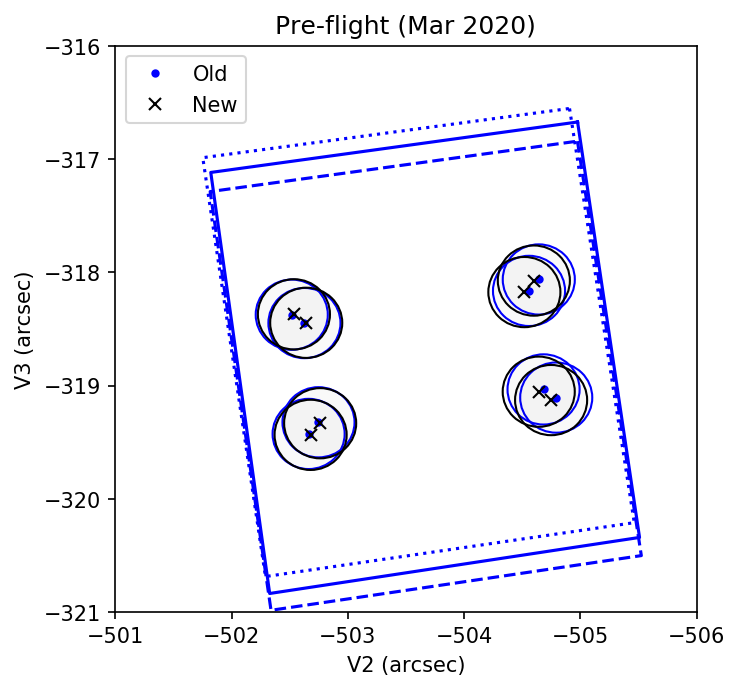

In [11]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()
plt.xlim(-501,-506)
plt.ylim(-321,-316)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')
    
plt.plot(v2_old_ch1,v3_old_ch1,'.',color='b',label='Old')
for i in range(0,v2_old_ch1.size):
    circle1 = mpl.patches.Circle((v2_old_ch1[i], v3_old_ch1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='b', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch1,v3_ch1,'x',color='black',label='New')
for i in range(0,v2_ch1.size):
    circle1 = mpl.patches.Circle((v2_ch1[i], v3_ch1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf1B['inscr_v2_corners'],siaf1B['inscr_v3_corners'],'--',color='b',linewidth=1.5)
plt.plot(siaf1C['inscr_v2_corners'],siaf1C['inscr_v3_corners'],':',color='b',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

### Ch2 point-source dithers ###

In [12]:
v2_ch2,v3_ch2=mrsd.makepattern_ch2(siaf2A,siaf2B,siaf2C)

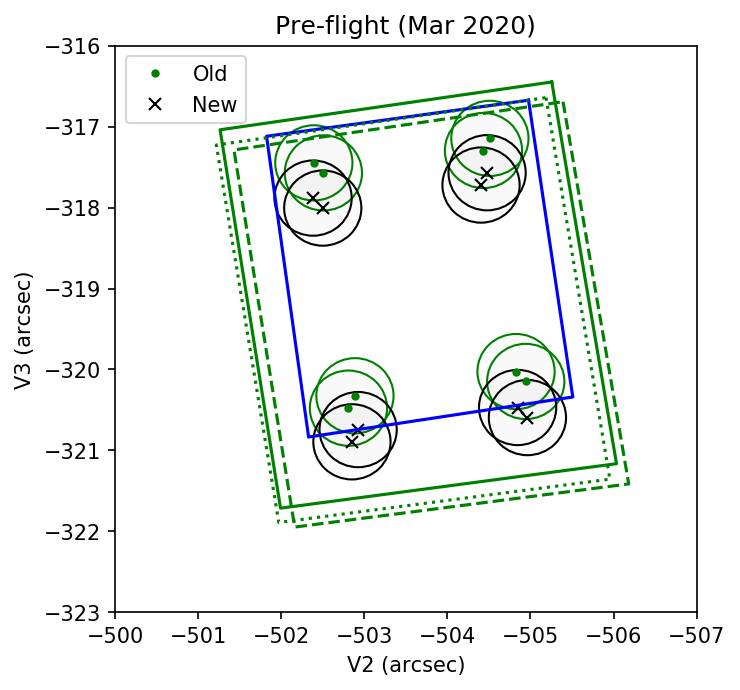

In [13]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-500,-507)
plt.ylim(-323,-316)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ch2,v3_old_ch2,'.',color='g',label='Old')
for i in range(0,v2_old_ch2.size):
    circle1 = mpl.patches.Circle((v2_old_ch2[i], v3_old_ch2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='g', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch2,v3_ch2,'x',color='black',label='New')
for i in range(0,v2_ch2.size):
    circle1 = mpl.patches.Circle((v2_ch2[i], v3_ch2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)  
    
plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf2B['inscr_v2_corners'],siaf2B['inscr_v3_corners'],'--',color='g',linewidth=1.5)
plt.plot(siaf2C['inscr_v2_corners'],siaf2C['inscr_v3_corners'],':',color='g',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

### Ch3 point-source dithers ###

In [14]:
v2_ch3,v3_ch3=mrsd.makepattern_ch3(siaf3A,siaf3B,siaf3C)

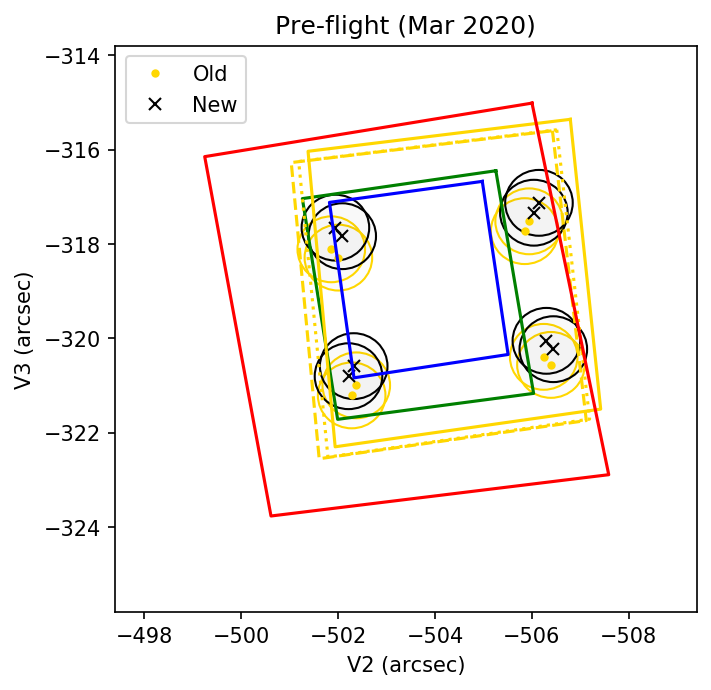

In [15]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ch3,v3_old_ch3,'.',color='gold',label='Old')
for i in range(0,v2_old_ch3.size):
    circle1 = mpl.patches.Circle((v2_old_ch3[i], v3_old_ch3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='gold', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch3,v3_ch3,'x',color='black',label='New')
for i in range(0,v2_ch3.size):
    circle1 = mpl.patches.Circle((v2_ch3[i], v3_ch3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)  
    
plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf3B['inscr_v2_corners'],siaf3B['inscr_v3_corners'],'--',color='gold',linewidth=1.5)
plt.plot(siaf3C['inscr_v2_corners'],siaf3C['inscr_v3_corners'],':',color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

### Ch4 point-source dithers ###

In [16]:
v2_ch4,v3_ch4=mrsd.makepattern_ch4(siaf4A,siaf4B,siaf4C)

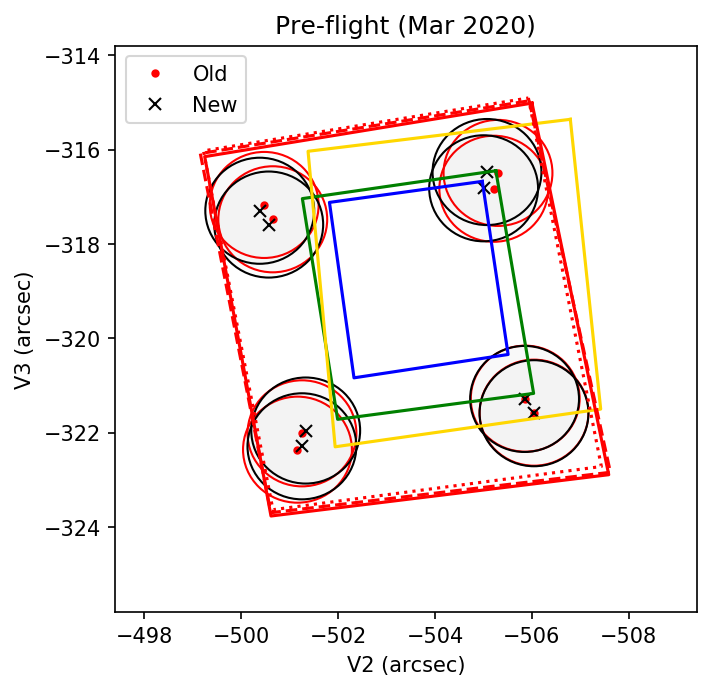

In [17]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ch4,v3_old_ch4,'.',color='r',label='Old')
for i in range(0,v2_old_ch4.size):
    circle1 = mpl.patches.Circle((v2_old_ch4[i], v3_old_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='r', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch4,v3_ch4,'x',color='black',label='New')
for i in range(0,v2_ch4.size):
    circle1 = mpl.patches.Circle((v2_ch4[i], v3_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.plot(siaf4B['inscr_v2_corners'],siaf4B['inscr_v3_corners'],'--',color='r',linewidth=1.5)
plt.plot(siaf4C['inscr_v2_corners'],siaf4C['inscr_v3_corners'],':',color='r',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

### Make the extended source patterns ###

In [18]:
v2_ext_all,v3_ext_all=mrsd.makepattern_ext_all(siaf1A,siaf1B,siaf1C)
v2_ext_ch1,v3_ext_ch1=mrsd.makepattern_ext_ChX(v2_ch1,v3_ch1,siaf1A)
v2_ext_ch2,v3_ext_ch2=mrsd.makepattern_ext_ChX(v2_ch2,v3_ch2,siaf2A)
v2_ext_ch3,v3_ext_ch3=mrsd.makepattern_ext_ChX(v2_ch3,v3_ch3,siaf3A)
v2_ext_ch4,v3_ext_ch4=mrsd.makepattern_ext_ChX(v2_ch4,v3_ch4,siaf4A)

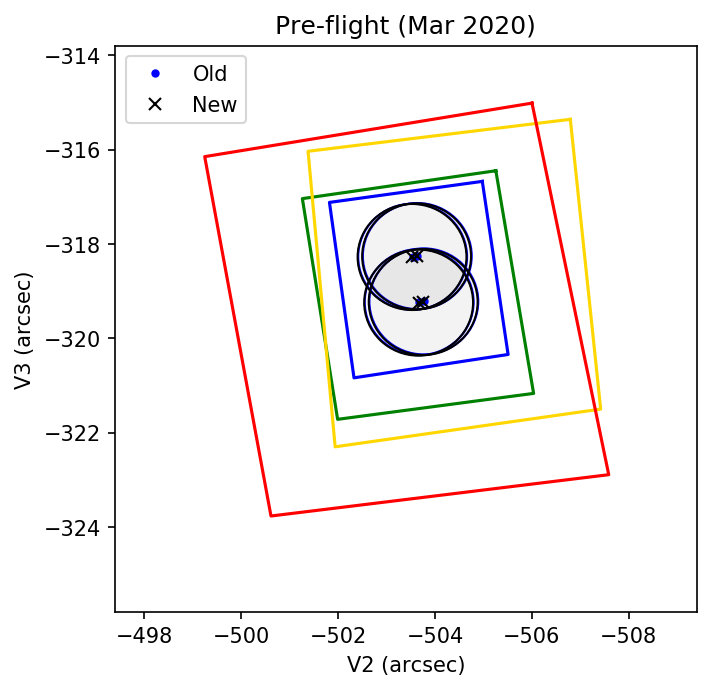

In [19]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_eall,v3_old_eall,'.',color='b',label='Old')
for i in range(0,v2_old_eall.size):
    circle1 = mpl.patches.Circle((v2_old_eall[i], v3_old_eall[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='b', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_all,v3_ext_all,'x',color='black',label='New')
for i in range(0,v2_ext_all.size):
    circle1 = mpl.patches.Circle((v2_ext_all[i], v3_ext_all[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

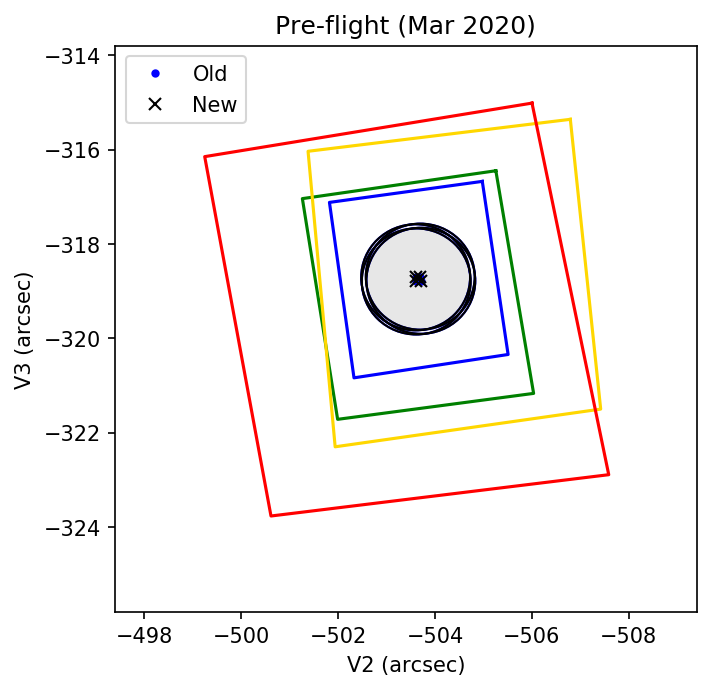

In [20]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech1,v3_old_ech1,'.',color='b',label='Old')
for i in range(0,v2_old_ech1.size):
    circle1 = mpl.patches.Circle((v2_old_ech1[i], v3_old_ech1[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='b', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch1,v3_ext_ch1,'x',color='black',label='New')
for i in range(0,v2_ext_ch1.size):
    circle1 = mpl.patches.Circle((v2_ext_ch1[i], v3_ext_ch1[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

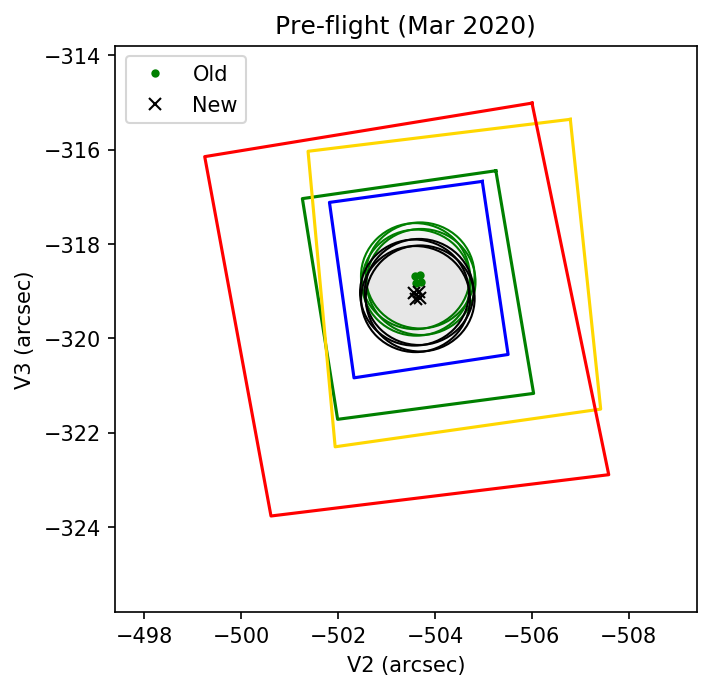

In [21]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech2,v3_old_ech2,'.',color='g',label='Old')
for i in range(0,v2_old_ech2.size):
    circle1 = mpl.patches.Circle((v2_old_ech2[i], v3_old_ech2[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='g', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch2,v3_ext_ch2,'x',color='black',label='New')
for i in range(0,v2_ext_ch2.size):
    circle1 = mpl.patches.Circle((v2_ext_ch2[i], v3_ext_ch2[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

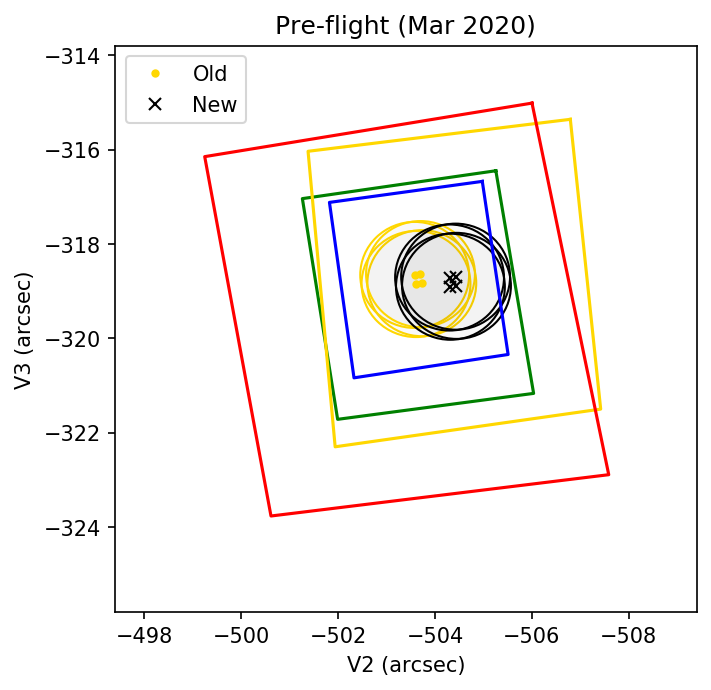

In [22]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech3,v3_old_ech3,'.',color='gold',label='Old')
for i in range(0,v2_old_ech3.size):
    circle1 = mpl.patches.Circle((v2_old_ech3[i], v3_old_ech3[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='gold', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch3,v3_ext_ch3,'x',color='black',label='New')
for i in range(0,v2_ext_ch3.size):
    circle1 = mpl.patches.Circle((v2_ext_ch3[i], v3_ext_ch3[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

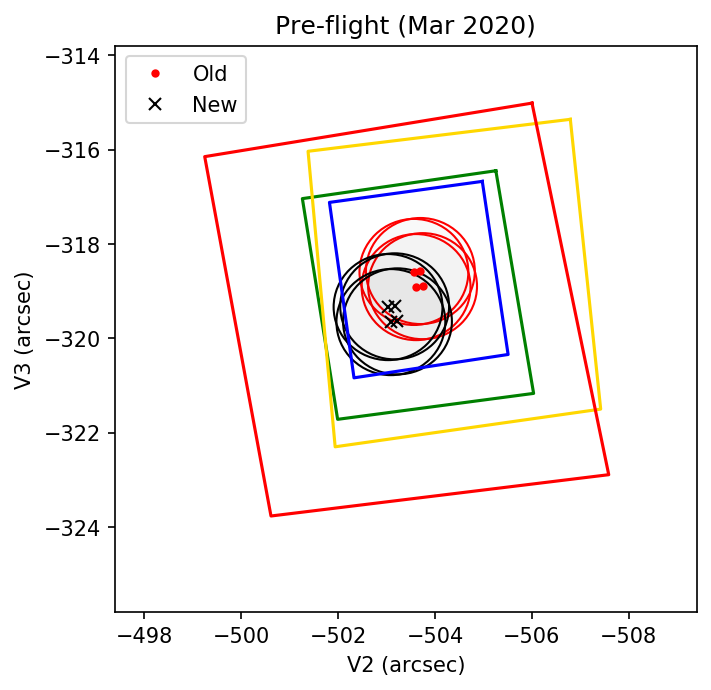

In [23]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech4,v3_old_ech4,'.',color='r',label='Old')
for i in range(0,v2_old_ech4.size):
    circle1 = mpl.patches.Circle((v2_old_ech4[i], v3_old_ech4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='r', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch4,v3_ext_ch4,'x',color='black',label='New')
for i in range(0,v2_ext_ch4.size):
    circle1 = mpl.patches.Circle((v2_ext_ch4[i], v3_ext_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='black', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Pre-flight ('+nowstring+')')
plt.legend()

### Put all of the patterns together and compute Ideal frame offsets ###

In [24]:
# So far each of these gave specific v2/v3 pointing locations.
# Now they need to be converted to xidl, yidl offsets relative to the pointing origin for a given dither pattern
# (i.e., where the undithered pointing is for a given channel)
# Note that this means the offsets (wrt A band) won't necessarily be symmetric around 0 xideal/yideal because
# they average over the FoV of bands A/B/C together.

In [25]:
# Positions index
index=np.arange(52)+1

# Ch1 point source pattern
v2_all,v3_all=v2_ch1,v3_ch1
ch_all=(np.ones(len(v2_ch1))).astype(int)
dx,dy=mrsd.compute_dxdyideal(v2_ch1,v3_ch1,siaf1A,siaf1A=siaf1A)
dx_all,dy_all=dx,dy
# Ch2 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch2),np.append(v3_all,v3_ch2)
ch_all=np.append(ch_all,(np.ones(len(v2_ch2))*2).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch2,v3_ch2,siaf2A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Ch3 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch3),np.append(v3_all,v3_ch3)
ch_all=np.append(ch_all,(np.ones(len(v2_ch3))*3).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch3,v3_ch3,siaf3A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Ch4 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch4),np.append(v3_all,v3_ch4)
ch_all=np.append(ch_all,(np.ones(len(v2_ch4))*4).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch4,v3_ch4,siaf4A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)

# Extended source ALL pattern
v2_all,v3_all=np.append(v2_all,v2_ext_all),np.append(v3_all,v3_ext_all)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_all))).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_all,v3_ext_all,siaf1A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch1 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch1),np.append(v3_all,v3_ext_ch1)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch1))).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch1,v3_ext_ch1,siaf1A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch2 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch2),np.append(v3_all,v3_ext_ch2)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch2))*2).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch2,v3_ext_ch2,siaf2A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch3 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch3),np.append(v3_all,v3_ext_ch3)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch3))*3).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch3,v3_ext_ch3,siaf3A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch4 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch4),np.append(v3_all,v3_ext_ch4)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch4))*4).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch4,v3_ext_ch4,siaf4A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)

### Write results to disk ###

In [26]:
mrsd.writeresults_mirisim(ch_all,v2_all,v3_all,outdir=data_dir)
mrsd.writeresults_prd(dx_all,dy_all,outdir=data_dir)
mrsd.writeresults_full(index,ch_all,v2_all,v3_all,dx_all,dy_all,outdir=data_dir)

### Generate QA plots to disk ###

In [27]:
allsiaf=[siaf1A,siaf1B,siaf1C,siaf2A,siaf2B,siaf2C,siaf3A,siaf3B,siaf3C,siaf4A,siaf4B,siaf4C]

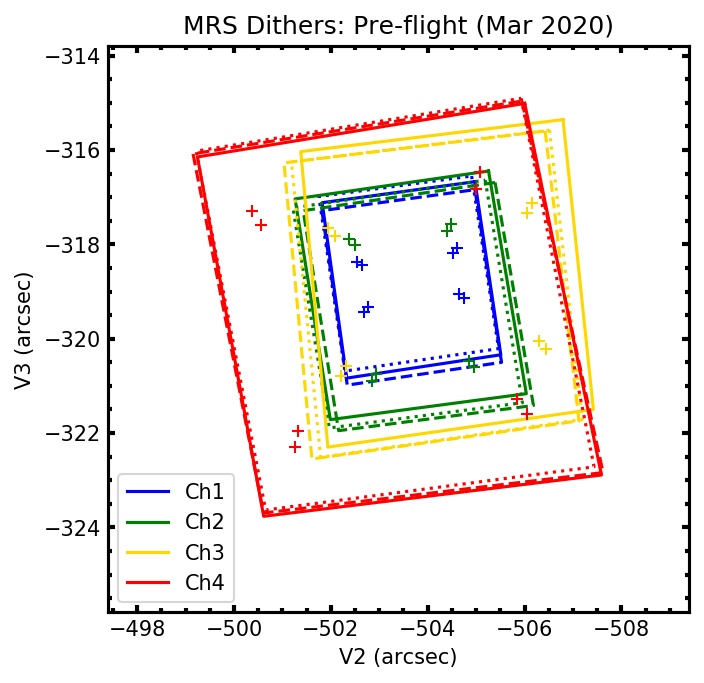

In [28]:
mrsd.qaplot_ptsourceloc(v2_all,v3_all,allsiaf,outdir=data_dir)

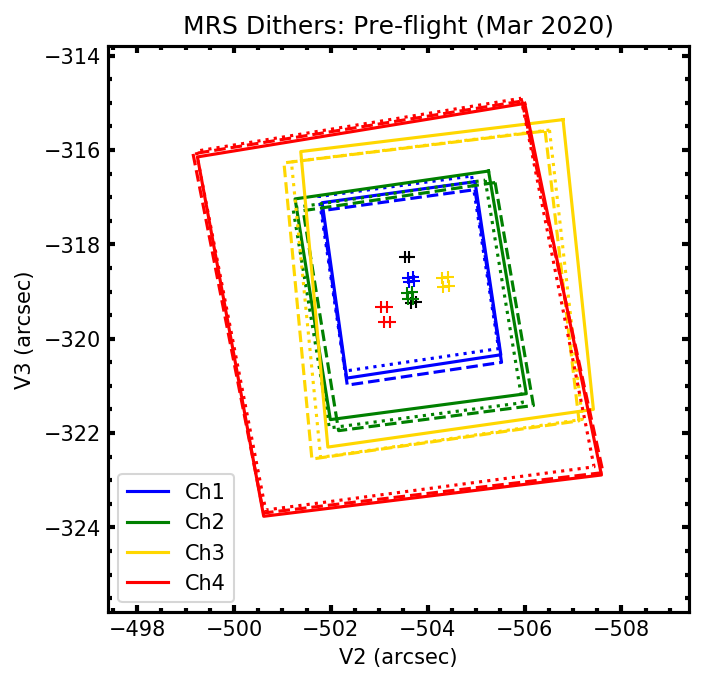

In [29]:
mrsd.qaplot_extsourceloc(v2_all,v3_all,allsiaf,outdir=data_dir)

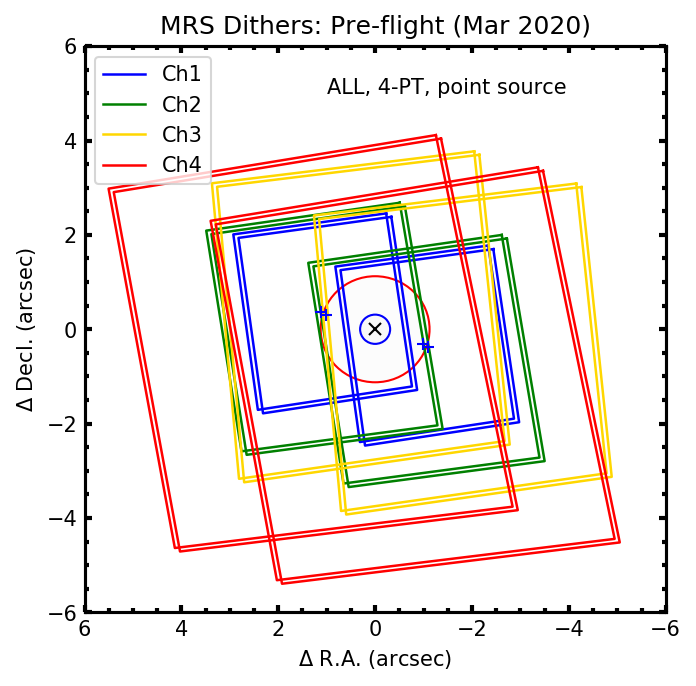

In [30]:
mrsd.qaplot_ps4all(v2_all,v3_all,dx_all,dy_all,allsiaf,outdir=data_dir)

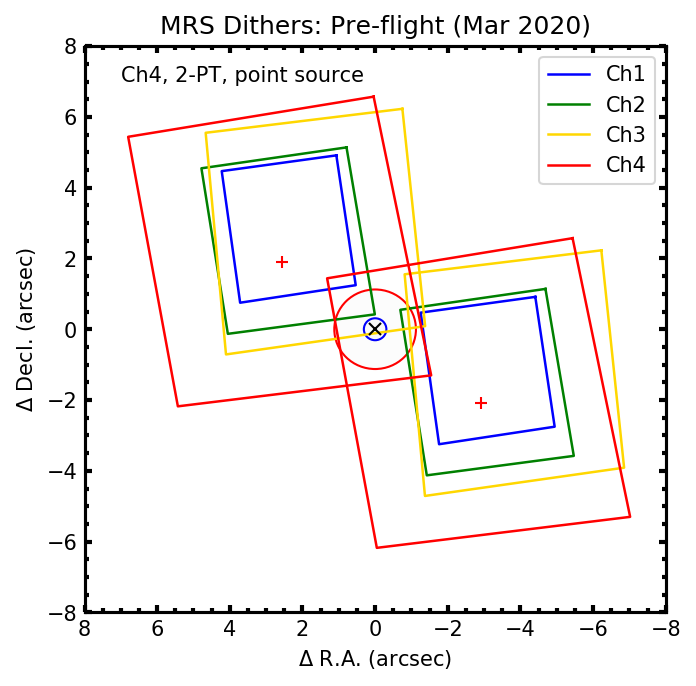

In [31]:
mrsd.qaplot_ps2ch4(v2_all,v3_all,dx_all,dy_all,allsiaf,outdir=data_dir)

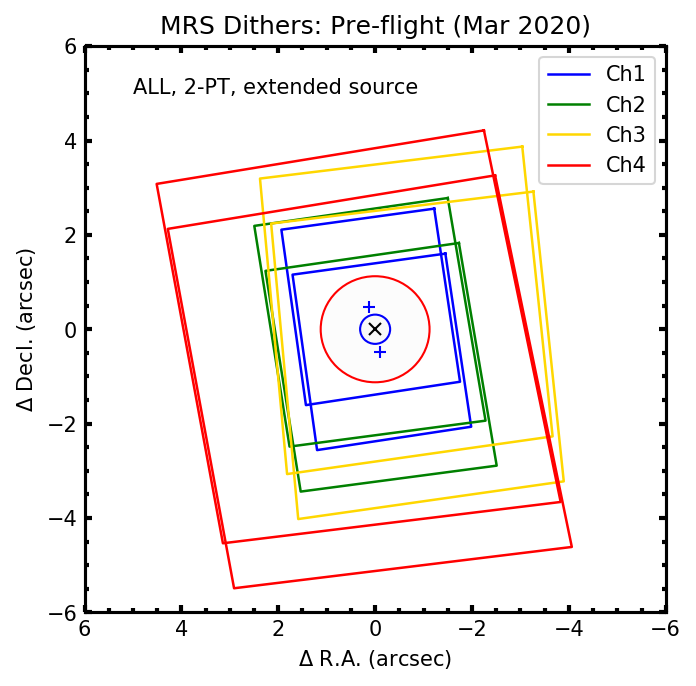

In [32]:
mrsd.qaplot_ext2all(v2_all,v3_all,dx_all,dy_all,allsiaf,outdir=data_dir)

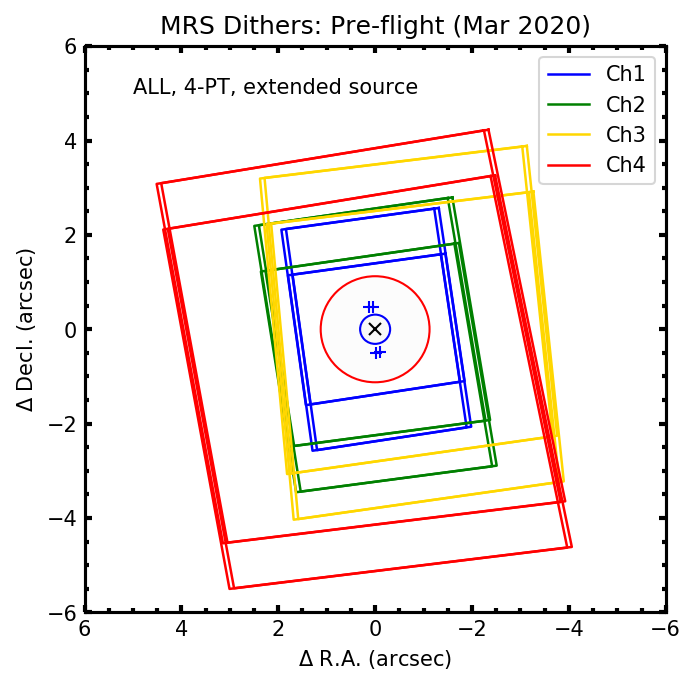

In [33]:
mrsd.qaplot_ext4all(v2_all,v3_all,dx_all,dy_all,allsiaf,outdir=data_dir)

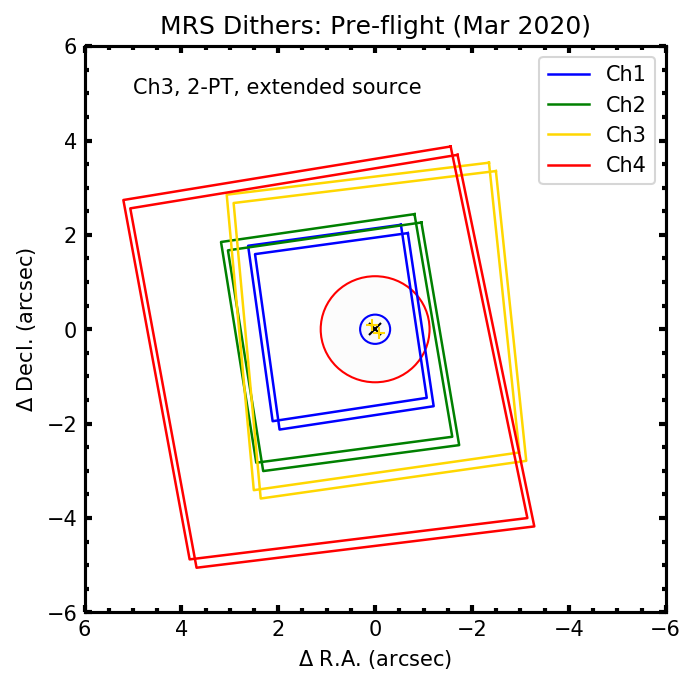

In [34]:
mrsd.qaplot_ext2ch3(v2_all,v3_all,dx_all,dy_all,allsiaf,outdir=data_dir)

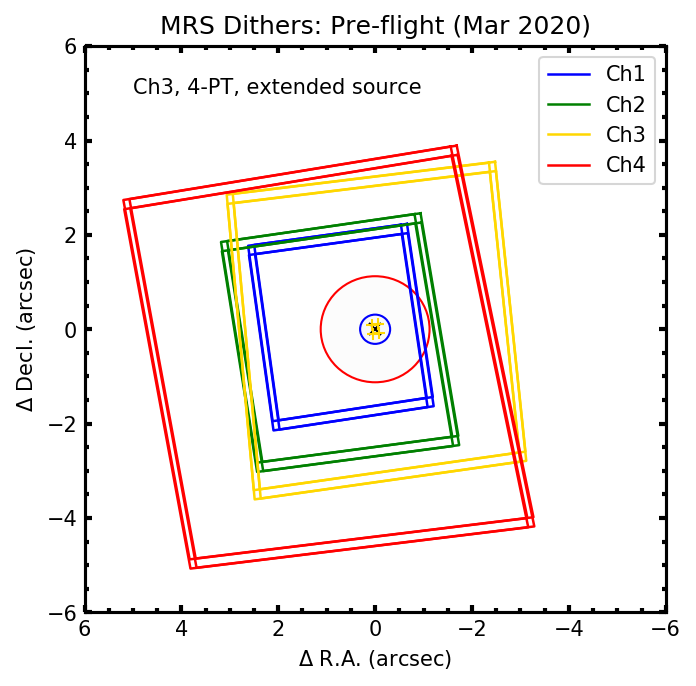

In [35]:
mrsd.qaplot_ext4ch3(v2_all,v3_all,dx_all,dy_all,allsiaf,outdir=data_dir)